In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandasql as pdsql
pysql = lambda q: pdsql.sqldf(q, globals())

import pickle

f = open('train_dict.pckl', 'rb')
train_dict = pickle.load(f)
f.close()
f = open('val_dict.pckl', 'rb')
val_dict = pickle.load(f)
f.close()
f = open('test_dict.pckl', 'rb')
test_dict = pickle.load(f)
f.close()
ens_train = pd.DataFrame(train_dict)
ens_val = pd.DataFrame(val_dict)
ens_test = pd.DataFrame(test_dict)

ft_ens=['nb_D','nb_H','nb_A','gb_D','gb_H','gb_A','filter_D','filter_H','filter_A','B365H','B365D','B365A']

In [2]:
from sklearn import linear_model
from sklearn.metrics import f1_score


C= [0.001, 0.01, 0.1, 1, 10, 100, 1000]
solver=['newton-cg', 'lbfgs', 'liblinear', 'sag']
n = range(100,1000,50)
lr= [0.0001, 0.001, 0.01, 0.1]


def pca_logreg_validation(C,solver,train,val,train_y,val_y):
    sc_max = -10000
    best=[]
    for s in solver:
        for cv in C:
            print s,cv
            lg = linear_model.LogisticRegression(C=cv,solver=s,n_jobs=-1,max_iter=100000)
            lg.fit(train,train_y)
            score = f1_score(val_y, lg.predict(val),average='weighted')
            if score>sc_max:
                best=lg
                sc_max=score
    return best
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

def pca_rf_validation(n_estimators,train,val,train_y,val_y):
    sc_max = -10000
    best=[]
    for n in n_estimators:
        rf = RandomForestClassifier(n_estimators=n,n_jobs=-1)
        rf.fit(train,train_y)
        score = f1_score(val_y, rf.predict(val),average='weighted')
        if score>sc_max:
            best=rf
            sc_max=score
    return best

n = range(100,1000,50)

#rf= rf_validation(n,train,val,ft,out)


#Função Naive Bayes
from sklearn.naive_bayes import GaussianNB

def pca_nb_validation(train,val,train_y,val_y):
    nb = GaussianNB()
    nb.fit(train,train_y)
    return nb


#Gradient Boosting
def pca_gb_validation(learning_rate,n_estimators,train,val,train_y,val_y):
    sc_max = -10000
    best=[]
    for n in n_estimators:
        for lr in learning_rate:
            gb = GradientBoostingClassifier(learning_rate=lr,n_estimators=n)
            gb.fit(train,train_y)
            score = f1_score(val_y, gb.predict(val),average='weighted')
            if score>sc_max:
                best=gb
                sc_max=score
    return best
from sklearn.neighbors import KNeighborsClassifier
def pca_knn_validation(algorithms,k,train,val,train_y,val_y):
    sc_max = -10000
    best=[]
    for alg in algorithms:
        for n in k:
            knn = KNeighborsClassifier(algorithm=alg,n_neighbors=n)
            knn.fit(train,train_y)
            score = f1_score(val_y, knn.predict(val),average='weighted')
            if score>sc_max:
                best=knn
                sc_max=score
        return best

def all_algorithms(train,val,test,train_y,val_y,test_y):
    logreg=pca_logreg_validation(C,solver,train,val,train_y,val_y)
    print "NB"
    nb= pca_nb_validation(train,val,train_y,val_y)
    print "RF"
    n = range(100,1000,50)
    rf= pca_rf_validation(n,train,val,train_y,val_y)
    lr= [0.0001, 0.001, 0.01, 0.1]
    print "GB"
    gb= pca_gb_validation(lr,n,train,val,train_y,val_y)
    print "KNN"
    k = range(1,100,2)
    algorithms = ['auto', 'ball_tree', 'kd_tree', 'brute']
    knn= pca_knn_validation(algorithms,k,train,val,train_y,val_y)
    #GaussianProcess
    ynaive = [train_y.mode()[0]]*len(test)
    naive = f1_score(test_y,ynaive,average='weighted')
    #print "logreg
    print "\t\tF1Score\t","      F1 macro\t","    F1 micro"
    print "Naive      ", naive,f1_score(test_y,ynaive,average='macro'),f1_score(test_y,ynaive,average='micro')
    print "LogReg     ", f1_score(test_y,logreg.predict(test),average='weighted'),f1_score(test_y,logreg.predict(test),average='macro'),f1_score(test_y,logreg.predict(test),average='micro')
    print "Naive Bayes", f1_score(test_y,nb.predict(test),average='weighted'),f1_score(test_y,nb.predict(test),average='macro'),f1_score(test_y,nb.predict(test),average='micro')
    print "Random F.  ", f1_score(test_y,rf.predict(test),average='weighted'),f1_score(test_y,rf.predict(test),average='macro'),f1_score(test_y,rf.predict(test),average='micro')
    print "G. Boost.  ", f1_score(test_y,gb.predict(test),average='weighted'),f1_score(test_y,gb.predict(test),average='macro'),f1_score(test_y,gb.predict(test),average='micro')
    print "KNN        ", f1_score(test_y,knn.predict(test),average='weighted'),f1_score(test_y,knn.predict(test),average='macro'),f1_score(test_y,knn.predict(test),average='micro')
    return logreg,nb,rf,gb,knn
#lr= [0.0001, 0.001, 0.01, 0.1]
logreg,nb,rf,gb,knn = all_algorithms(ens_train[ft_ens],ens_val[ft_ens],ens_test[ft_ens],ens_train['Output'],ens_val['Output'],ens_test['Output'])
#logreg_lda=pca_logreg_validation(C,solver,ens_train[ft_ens],ens_val[ft_ens],ens_train['Output'],ens_val['Output'])
#print "NB"
#nb_lda= pca_nb_validation(ens_train[ft_ens],ens_val[ft_ens],ens_train['Output'],ens_val['Output'])
#print "RF"
#n = range(100,1000,50)
#rf_lda= pca_rf_validation(n,ens_train[ft_ens],ens_val[ft_ens],ens_train['Output'],ens_val['Output'])
#lr= [0.0001, 0.001, 0.01, 0.1]
#print "GB"
#gb_lda= pca_gb_validation(lr,n,ens_train[ft_ens],ens_val[ft_ens],ens_train['Output'],ens_val['Output'])

#GaussianProcess
#ynaive = [ens_train['Output'].mode()[0]]*len(ens_test)
#naive = f1_score(ens_test['Output'],ynaive,average='weighted')
#print "logreg_lda"
#print "\t\tF1Score\t","      F1 macro\t","    F1 micro"
#print "Naive      ", naive,f1_score(ens_test['Output'],ynaive,average='macro'),f1_score(ens_test['Output'],ynaive,average='micro')
#print "LogReg     ", f1_score(ens_test['Output'],logreg_lda.predict(ens_test[ft_ens]),average='weighted'),f1_score(ens_test['Output'],logreg_lda.predict(ens_test[ft_ens]),average='macro'),f1_score(ens_test['Output'],logreg_lda.predict(ens_test[ft_ens]),average='micro')
#print "Naive Bayes", f1_score(ens_test['Output'],nb_lda.predict(ens_test[ft_ens]),average='weighted'),f1_score(ens_test['Output'],nb_lda.predict(ens_test[ft_ens]),average='macro'),f1_score(ens_test['Output'],nb_lda.predict(ens_test[ft_ens]),average='micro')
#print "Random F.  ", f1_score(ens_test['Output'],rf_lda.predict(ens_test[ft_ens]),average='weighted'),f1_score(ens_test['Output'],rf_lda.predict(ens_test[ft_ens]),average='macro'),f1_score(ens_test['Output'],rf_lda.predict(ens_test[ft_ens]),average='micro')
#print "G. Boost.  ", f1_score(ens_test['Output'],gb_lda.predict(ens_test[ft_ens]),average='weighted'),f1_score(ens_test['Output'],gb_lda.predict(ens_test[ft_ens]),average='macro'),f1_score(ens_test['Output'],gb_lda.predict(ens_test[ft_ens]),average='micro')

newton-cg 0.001
newton-cg 0.01


/home/felipef/anaconda2/envs/gl-env/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


newton-cg 0.1
newton-cg 1
newton-cg 10
newton-cg 100
newton-cg 1000
lbfgs 0.001
lbfgs 0.01
lbfgs 0.1
lbfgs 1
lbfgs 10
lbfgs 100
lbfgs 1000
liblinear 0.001
liblinear 0.01
liblinear 0.1
liblinear 1
liblinear 10
liblinear 100
liblinear 1000
sag 0.001
sag 0.01
sag 0.1
sag 1
sag 10
sag 100
sag 1000
NB
RF
GB
KNN
		F1Score	      F1 macro	    F1 micro
Naive       0.274881660519 0.205550071295 0.445765937203
LogReg      0.437954423809 0.381147231751 0.526165556613
Naive Bayes 0.467510817972 0.444941148732 0.460513796384
Random F.   0.488500473489 0.447087017112 0.52568981922
G. Boost.   0.464885519597 0.417504726482 0.522359657469
KNN         0.472760548582 0.429262680811 0.517126546147


# Vamos agora usar o metodo chi2

In [3]:
from sklearn.feature_selection import SelectKBest, chi2
ft_rank,pvalue = chi2(ens_train[ft_ens],ens_train['Output'])

rank={}
i=0
ft_chi=[]
for v in ft_rank:
    if v>=100:
        rank[i]=v
        
    i=i+1

import operator

sorted_x = sorted(rank.items(), key=operator.itemgetter(1),reverse=True)
selected_ft=[]
for key,value in sorted_x:
    selected_ft.append(ft_ens[key])
    print ft_ens[key],value,pvalue[key]
    

B365A 3826.89364145 0.0
B365H 1687.64607087 0.0
nb_A 163.511548054 3.11830417695e-36
gb_A 154.24205616 3.21190777084e-34
B365D 144.009813946 5.35385039801e-32
gb_H 116.580897237 4.83926959516e-26
nb_H 107.448498148 4.65430760779e-24


In [4]:
logreg_chi,nb_chi,rf_chi,gb_chi,knn_chi = all_algorithms(ens_train[selected_ft],ens_val[selected_ft],ens_test[selected_ft],ens_train['Output'],ens_val['Output'],ens_test['Output'])

newton-cg 0.001
newton-cg 0.01
newton-cg 0.1
newton-cg 1
newton-cg 10
newton-cg 100
newton-cg 1000
lbfgs 0.001
lbfgs 0.01
lbfgs 0.1
lbfgs 1
lbfgs 10
lbfgs 100
lbfgs 1000
liblinear 0.001
liblinear 0.01
liblinear 0.1
liblinear 1
liblinear 10
liblinear 100
liblinear 1000
sag 0.001
sag 0.01
sag 0.1
sag 1
sag 10
sag 100
sag 1000
NB
RF
GB
KNN
		F1Score	      F1 macro	    F1 micro
Naive       0.274881660519 0.205550071295 0.445765937203
LogReg      0.433981948046 0.377098741803 0.522359657469
Naive Bayes 0.474011708908 0.446855577557 0.472882968601
Random F.   0.462005574499 0.421702784958 0.493339676499
G. Boost.   0.463118943008 0.422451008305 0.499048525214
KNN         0.473539834518 0.433892005648 0.505233111323


Como podemos observar a diferença entre o Chi2 e todas as features não é significativa. Entretanto o Chi2 nao apresentou um f1score maior. Vamos desconsiderar o chi2

# Vamos usar o PCA 

0
1
2
3
4
5
6
7
8
9
10
11


/home/felipef/anaconda2/envs/gl-env/lib/python2.7/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


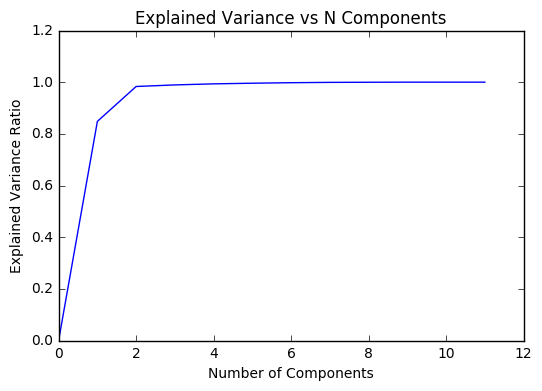

In [5]:
from sklearn.decomposition import PCA, IncrementalPCA
import numpy as np
explained=[]
for i in range(len(ft_ens)):
    print i
    pca = PCA(n_components=i)
    pca.fit(ens_train[ft_ens]).transform(ens_train[ft_ens])
    explained.append(np.sum(pca.explained_variance_ratio_))



plt.figure()
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left', shadow=False, scatterpoints=1)
plt.plot(range(0,len(ft_ens)),explained)
plt.title('Explained Variance vs N Components')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.show()

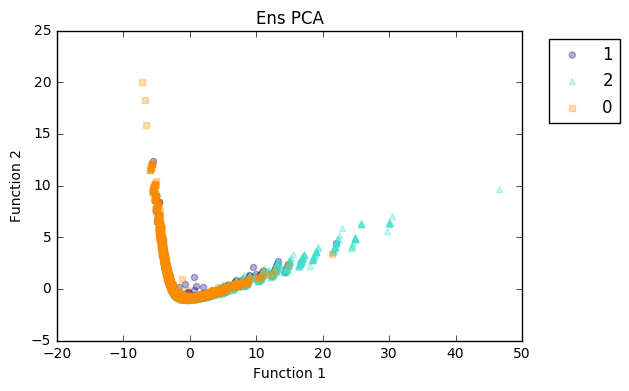

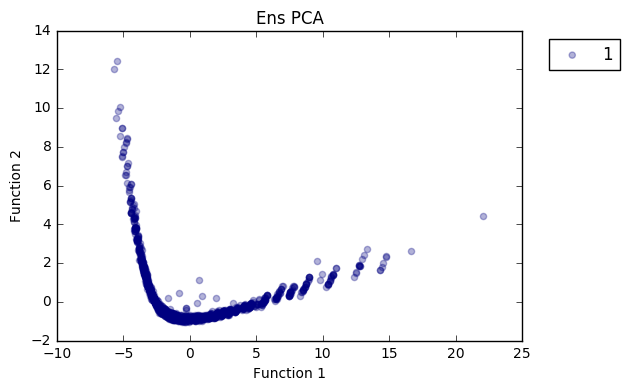

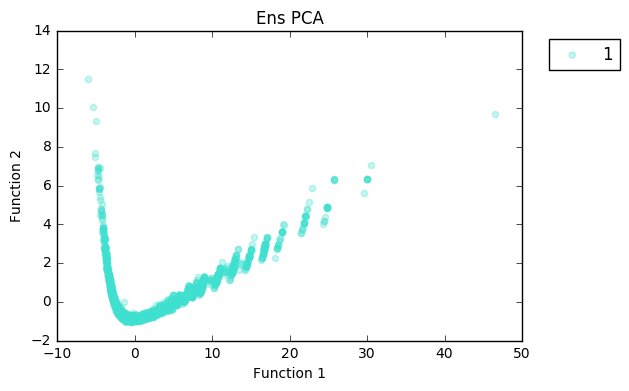

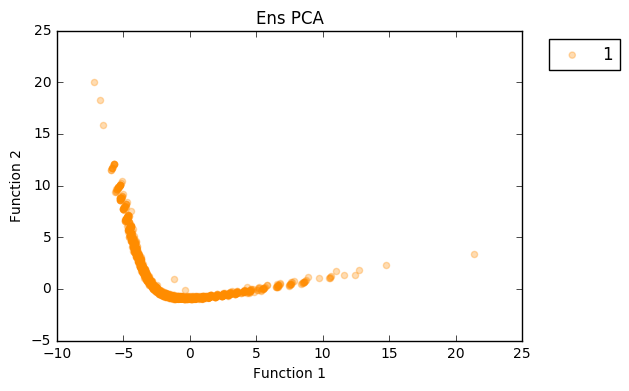

In [6]:
pca = PCA(n_components=2)
X_r2= pca.fit(ens_train[ft_ens]).transform(ens_train[ft_ens])
target_names = ['1', '2', '0']
colors = ['navy', 'turquoise', 'darkorange']
lw = 2

pca_train = pca.transform(ens_train[ft_ens])
pca_val = pca.transform(ens_val[ft_ens])
pca_test = pca.transform(ens_test[ft_ens])


plt.figure()

for color, i, target_name,m in zip(colors, [ 0,1,2], target_names,["o","^","s"]):
    plt.scatter(X_r2[ens_train['Output'] == i, 0],X_r2[ens_train['Output'] == i, 1],alpha=.3, color=color,
                label=target_name, marker=m)
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left', shadow=False, scatterpoints=1)
plt.title('Ens PCA')
plt.xlabel('Function 1')
plt.ylabel('Function 2')

plt.show()

plt.figure()

for color, i, target_name,m in zip(['navy'], [ 0], target_names,["o","^","s"]):
    plt.scatter(X_r2[ens_train['Output'] == i, 0],X_r2[ens_train['Output'] == i, 1],alpha=.3, color=color,
                label=target_name, marker=m)
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left', shadow=False, scatterpoints=1)
plt.title('Ens PCA')
plt.xlabel('Function 1')
plt.ylabel('Function 2')

plt.show()

plt.figure()

for color, i, target_name,m in zip(['turquoise'], [1], target_names,["o","^","s"]):
    plt.scatter(X_r2[ens_train['Output'] == i, 0],X_r2[ens_train['Output'] == i, 1],alpha=.3, color=color,
                label=target_name, marker=m)
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left', shadow=False, scatterpoints=1)
plt.title('Ens PCA')
plt.xlabel('Function 1')
plt.ylabel('Function 2')

plt.show()

plt.figure()

for color, i, target_name,m in zip(['darkorange'], [2], target_names,["o","^","s"]):
    plt.scatter(X_r2[ens_train['Output'] == i, 0],X_r2[ens_train['Output'] == i, 1],alpha=.3, color=color,
                label=target_name, marker=m)
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left', shadow=False, scatterpoints=1)
plt.title('Ens PCA')
plt.xlabel('Function 1')
plt.ylabel('Function 2')

plt.show()

In [7]:
logreg_pca,nb_pca,rf_pca,gb_pca,knn_pca = all_algorithms(pca_train,pca_val,pca_test,ens_train['Output'],ens_val['Output'],ens_test['Output'])

newton-cg 0.001
newton-cg 0.01
newton-cg 0.1
newton-cg 1
newton-cg 10
newton-cg 100
newton-cg 1000
lbfgs 0.001
lbfgs 0.01
lbfgs 0.1
lbfgs 1
lbfgs 10
lbfgs 100
lbfgs 1000
liblinear 0.001
liblinear 0.01
liblinear 0.1
liblinear 1
liblinear 10
liblinear 100
liblinear 1000
sag 0.001
sag 0.01
sag 0.1
sag 1
sag 10
sag 100
sag 1000
NB
RF
GB
KNN
		F1Score	      F1 macro	    F1 micro
Naive       0.274881660519 0.205550071295 0.445765937203
LogReg      0.441553092331 0.385056632833 0.526165556613
Naive Bayes 0.410852855626 0.351853938269 0.512369172217
Random F.   0.448624788674 0.416090766633 0.461941008563
G. Boost.   0.455169200629 0.409386574074 0.502378686965
KNN         0.46726172573 0.424150314692 0.509990485252


# Usando agora o LDA

0
1
2
3
4
5


/home/felipef/anaconda2/envs/gl-env/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:389: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


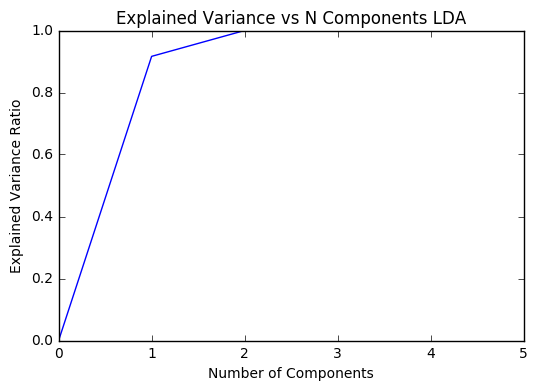

In [8]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
explained_lda=[]
for i in range(6):
    print i
    lda = LinearDiscriminantAnalysis(n_components=i)
    lda.fit(ens_train[ft_ens],ens_train['Output']).transform(ens_train[ft_ens])
    explained_lda.append(np.sum(lda.explained_variance_ratio_))



plt.figure()
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left', shadow=False, scatterpoints=1)
plt.plot(range(0,6),explained_lda)
plt.title('Explained Variance vs N Components LDA')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.show()

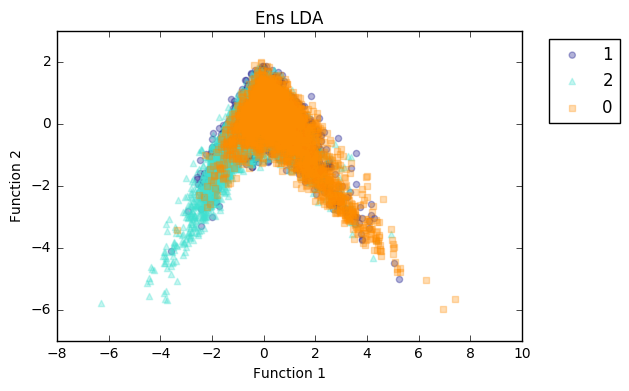

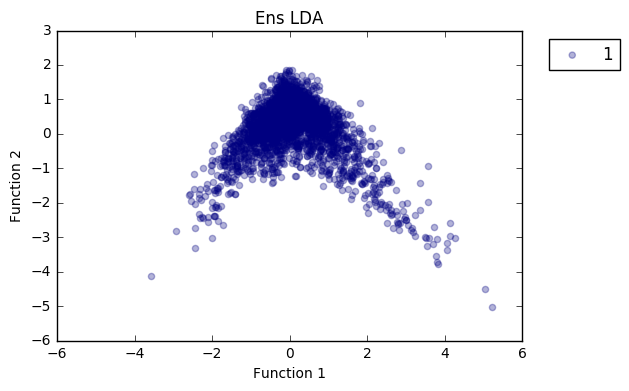

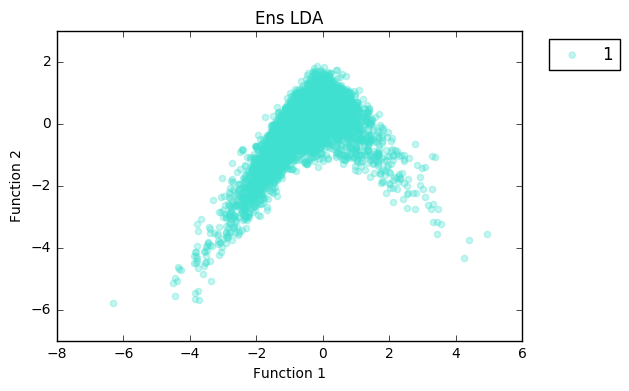

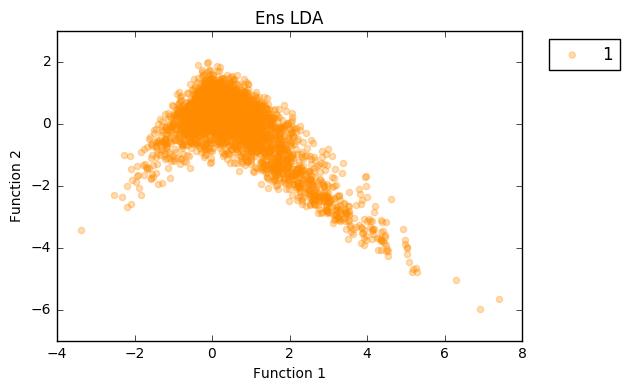

In [9]:
lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(ens_train[ft_ens],ens_train['Output']).transform(ens_train[ft_ens])
target_names = ['1', '2', '0']
colors = ['navy', 'turquoise', 'darkorange']
lw = 2

lda_train = lda.transform(ens_train[ft_ens])
lda_val = lda.transform(ens_val[ft_ens])
lda_test = lda.transform(ens_test[ft_ens])


for color, i, target_name,m in zip(colors, [ 0,1,2], target_names,["o","^","s"]):
    plt.scatter(X_r2[ens_train['Output'] == i, 0],X_r2[ens_train['Output'] == i, 1],alpha=.3, color=color,
                label=target_name, marker=m)
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left', shadow=False, scatterpoints=1)
plt.title('Ens LDA')
plt.xlabel('Function 1')
plt.ylabel('Function 2')

plt.show()

plt.figure()

for color, i, target_name,m in zip(['navy'], [ 0], target_names,["o","^","s"]):
    plt.scatter(X_r2[ens_train['Output'] == i, 0],X_r2[ens_train['Output'] == i, 1],alpha=.3, color=color,
                label=target_name, marker=m)
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left', shadow=False, scatterpoints=1)
plt.title('Ens LDA')
plt.xlabel('Function 1')
plt.ylabel('Function 2')

plt.show()

plt.figure()

for color, i, target_name,m in zip(['turquoise'], [1], target_names,["o","^","s"]):
    plt.scatter(X_r2[ens_train['Output'] == i, 0],X_r2[ens_train['Output'] == i, 1],alpha=.3, color=color,
                label=target_name, marker=m)
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left', shadow=False, scatterpoints=1)
plt.title('Ens LDA')
plt.xlabel('Function 1')
plt.ylabel('Function 2')

plt.show()

plt.figure()

for color, i, target_name,m in zip(['darkorange'], [ 2], target_names,["o","^","s"]):
    plt.scatter(X_r2[ens_train['Output'] == i, 0],X_r2[ens_train['Output'] == i, 1],alpha=.3, color=color,
                label=target_name, marker=m)
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left', shadow=False, scatterpoints=1)
plt.title('Ens LDA')
plt.xlabel('Function 1')
plt.ylabel('Function 2')

plt.show()

In [10]:
logreg_lda,nb_lda,rf_lda,gb_lda,knn_lda = all_algorithms(lda_train,lda_val,lda_test,ens_train['Output'],ens_val['Output'],ens_test['Output'])

newton-cg 0.001
newton-cg 0.01
newton-cg 0.1
newton-cg 1
newton-cg 10
newton-cg 100
newton-cg 1000
lbfgs 0.001
lbfgs 0.01
lbfgs 0.1
lbfgs 1
lbfgs 10
lbfgs 100
lbfgs 1000
liblinear 0.001
liblinear 0.01
liblinear 0.1
liblinear 1
liblinear 10
liblinear 100
liblinear 1000
sag 0.001
sag 0.01
sag 0.1
sag 1
sag 10
sag 100
sag 1000
NB
RF
GB
KNN
		F1Score	      F1 macro	    F1 micro
Naive       0.274881660519 0.205550071295 0.445765937203
LogReg      0.433109789604 0.376272442763 0.520456707897
Naive Bayes 0.466154260691 0.425580274063 0.502854424358
Random F.   0.452756633378 0.420277466598 0.467649857279
G. Boost.   0.44720792819 0.397213486724 0.512369172217
KNN         0.452714863791 0.406605597565 0.50475737393


# Usando o sistema de Filtro

In [11]:
sf_train = pysql("Select * from ens_train where B365H<= 1.5 or B365A<=1.5")
sf_val = pysql("Select * from ens_val where B365H<= 1.5 or B365A<=1.5")
sf_test = pysql("Select * from ens_test where B365H<= 1.5 or B365A<=1.5")

f_train = pysql("Select * from ens_train where (B365H between 1.51 and 2.20) or (B365A between 1.51 and 2.20)")
f_test = pysql("Select * from ens_test where (B365H between 1.51 and 2.20) or (B365A between 1.51 and 2.20)")
f_val = pysql("Select * from ens_val where (B365H between 1.51 and 2.20) or (B365A between 1.51 and 2.20)")

eq_train = pysql("Select * from ens_train where B365H>=2.22 and B365A>=2.22")
eq_test = pysql("Select * from ens_test where B365H>=2.22 and B365A>=2.22")
eq_val = pysql("Select * from ens_val where B365H>=2.22 and B365A>=2.22")




# LDA- Filtro

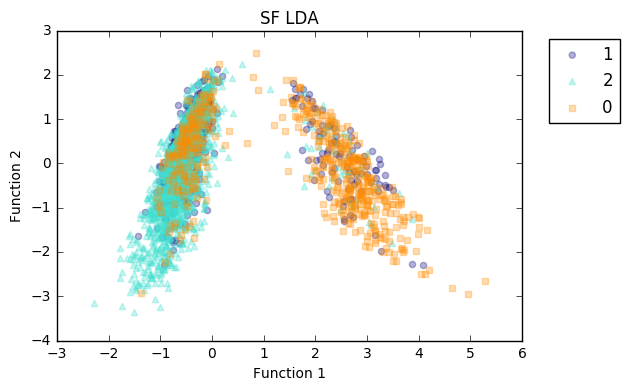

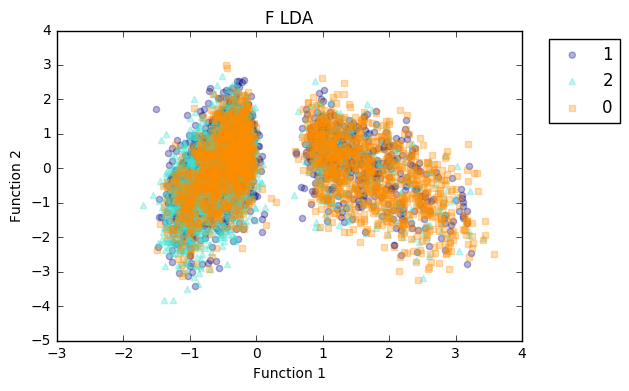

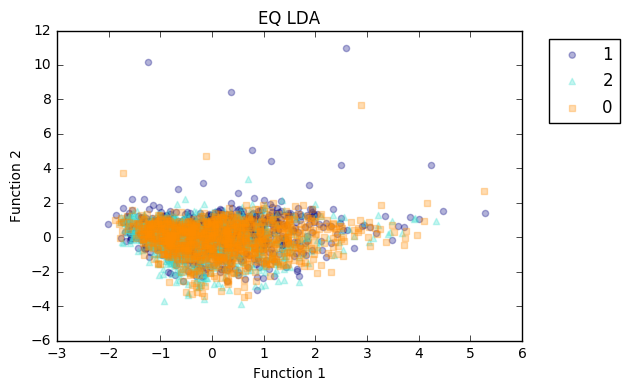

In [12]:
out = 'Output'
-

In [13]:
print "SF"
sf_logreg_lda,sf_nb_lda,sf_rf_lda,sf_gb_lda,sf_knn_lda = all_algorithms(sf_train_lda,sf_val_lda,sf_test_lda,sf_train['Output'],sf_val['Output'],sf_test['Output'])

SF
newton-cg 0.001
newton-cg 0.01
newton-cg 0.1
newton-cg 1
newton-cg 10
newton-cg 100
newton-cg 1000
lbfgs 0.001
lbfgs 0.01
lbfgs 0.1
lbfgs 1
lbfgs 10
lbfgs 100
lbfgs 1000
liblinear 0.001
liblinear 0.01
liblinear 0.1
liblinear 1
liblinear 10
liblinear 100
liblinear 1000
sag 0.001
sag 0.01
sag 0.1
sag 1
sag 10
sag 100
sag 1000
NB
RF
GB
KNN
		F1Score	      F1 macro	    F1 micro
Naive       0.456427955134 0.251366120219 0.605263157895
LogReg      0.702567847333 0.544833417398 0.769736842105
Naive Bayes 0.70013239188 0.542365401589 0.765350877193
Random F.   0.694101825784 0.561910971715 0.725877192982
G. Boost.   0.700617326575 0.543047902271 0.767543859649
KNN         0.70399936014 0.551694550943 0.765350877193


In [14]:
print "Favorito"
f_logreg_lda,f_nb_lda,f_rf_lda,f_gb_lda,f_knn_lda = all_algorithms(f_train_lda,f_val_lda,f_test_lda,f_train['Output'],f_val['Output'],f_test['Output'])

Favorito
newton-cg 0.001
newton-cg 0.01
newton-cg 0.1
newton-cg 1
newton-cg 10
newton-cg 100
newton-cg 1000
lbfgs 0.001
lbfgs 0.01
lbfgs 0.1
lbfgs 1
lbfgs 10
lbfgs 100
lbfgs 1000
liblinear 0.001
liblinear 0.01
liblinear 0.1
liblinear 1
liblinear 10
liblinear 100
liblinear 1000
sag 0.001
sag 0.01
sag 0.1
sag 1
sag 10
sag 100
sag 1000
NB
RF
GB
KNN
		F1Score	      F1 macro	    F1 micro
Naive       0.268692610816 0.203642747422 0.43981042654
LogReg      0.425196304603 0.37182024561 0.510900473934
Naive Bayes 0.426979229396 0.373877693255 0.511848341232
Random F.   0.410929245448 0.379811700334 0.422748815166
G. Boost.   0.427150227586 0.374498145431 0.508056872038
KNN         0.437705712539 0.393377435448 0.491943127962


In [15]:
print "Equilibrado"
eq_logreg_lda,eq_nb_lda,eq_rf_lda,eq_gb_lda,eq_knn_lda = all_algorithms(eq_train_lda,eq_val_lda,eq_test_lda,eq_train['Output'],eq_val['Output'],eq_test['Output'])

Equilibrado
newton-cg 0.001
newton-cg 0.01
newton-cg 0.1
newton-cg 1
newton-cg 10
newton-cg 100
newton-cg 1000
lbfgs 0.001
lbfgs 0.01
lbfgs 0.1
lbfgs 1
lbfgs 10
lbfgs 100
lbfgs 1000
liblinear 0.001
liblinear 0.01
liblinear 0.1
liblinear 1
liblinear 10
liblinear 100
liblinear 1000
sag 0.001
sag 0.01
sag 0.1
sag 1
sag 10
sag 100
sag 1000
NB
RF
GB
KNN
		F1Score	      F1 macro	    F1 micro
Naive       0.166666666667 0.166666666667 0.333333333333
LogReg      0.394044124235 0.39296974235 0.419627749577
Naive Bayes 0.377379558034 0.376427939109 0.41116751269
Random F.   0.356309670215 0.355428459285 0.358714043993
G. Boost.   0.388635251073 0.387738917617 0.404399323181
KNN         0.393090275369 0.393482663127 0.399323181049


In [16]:
import warnings
warnings.filterwarnings("ignore")
filter_pr=[]
for index,row in ens_test.iterrows():
    if row['B365H']<= 1.5 or row['B365A']<= 1.5:
        r = lda_sf.transform(row[ft_ens])
        filter_pr.append(sf_knn_lda.predict(r))
    elif row['B365H']<= 2.2 or row['B365A']<= 2.2:
        r = lda_f.transform(row[ft_ens])
        filter_pr.append(f_knn_lda.predict(r))
    else:
        r = lda_eq.transform(row[ft_ens])
        filter_pr.append(eq_logreg_lda.predict(r))

print "Filter"
print "\t\tF1Score\t","      F1 macro\t","    F1 micro"
print "Filter.  ", f1_score(ens_test['Output'],filter_pr,average='weighted'),f1_score(ens_test['Output'],filter_pr,average='macro'),f1_score(ens_test['Output'],filter_pr,average='micro')

Filter
		F1Score	      F1 macro	    F1 micro
Filter.   0.483300716891 0.438910600914 0.530922930542


# Agora vamos fazer um filtro diferente

In [17]:
sf_train_h = pysql("Select * from ens_train where B365H<= 1.5")
sf_val_h = pysql("Select * from ens_val where B365H<= 1.5")
sf_test_h = pysql("Select * from ens_test where B365H<= 1.5")

sf_train_a = pysql("Select * from ens_train where B365A<= 1.5")
sf_val_a = pysql("Select * from ens_val where B365A<= 1.5")
sf_test_a = pysql("Select * from ens_test where B365A<= 1.5")


f_train_h = pysql("Select * from ens_train where (B365H between 1.51 and 2.20)")
f_test_h = pysql("Select * from ens_test where (B365H between 1.51 and 2.20)")
f_val_h = pysql("Select * from ens_val where (B365H between 1.51 and 2.20)")

f_train_a = pysql("Select * from ens_train where (B365A between 1.51 and 2.20)")
f_test_a = pysql("Select * from ens_test where (B365A between 1.51 and 2.20)")
f_val_a = pysql("Select * from ens_val where (B365A between 1.51 and 2.20)")

eq_train = pysql("Select * from ens_train where B365H>=2.22 and B365A>=2.22")
eq_test = pysql("Select * from ens_test where B365H>=2.22 and B365A>=2.22")
eq_val = pysql("Select * from ens_val where B365H>=2.22 and B365A>=2.22")


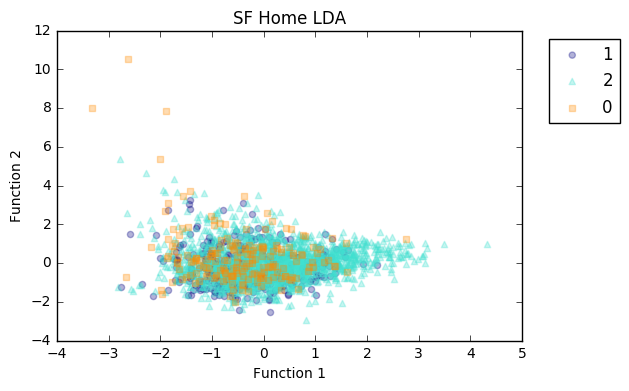

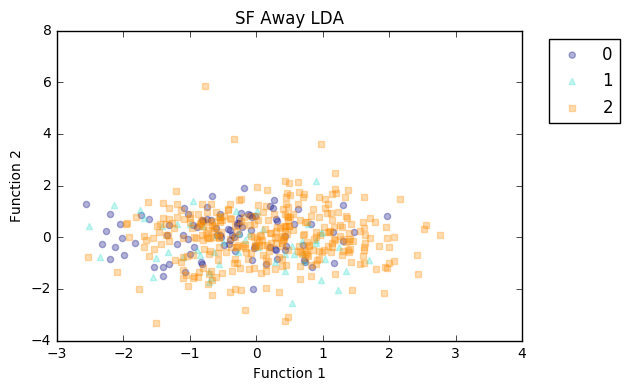

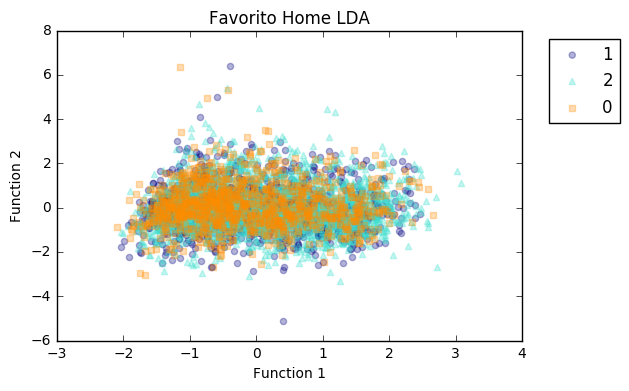

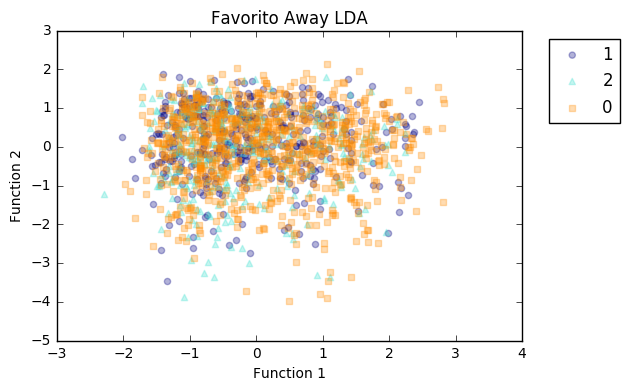

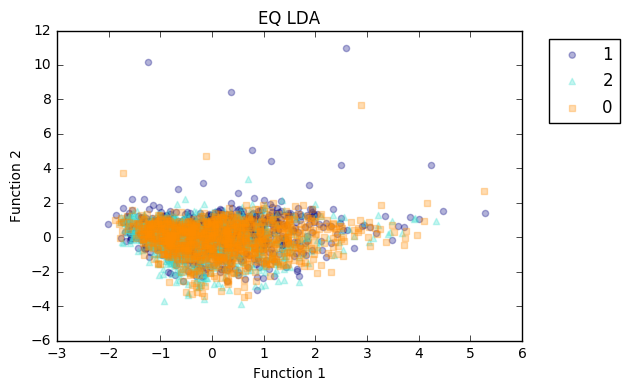

In [18]:
out = 'Output'
lda_sf_h = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda_sf_h.fit(sf_train_h[ft_ens],sf_train_h['Output']).transform(sf_train_h[ft_ens])
target_names = ['1', '2', '0']
colors = ['navy', 'turquoise', 'darkorange']
lw = 2
sf_train_h_lda = lda_sf_h.transform(sf_train_h[ft_ens])
sf_test_h_lda = lda_sf_h.transform(sf_test_h[ft_ens])
sf_val_h_lda = lda_sf_h.transform(sf_val_h[ft_ens])


plt.figure()

for color, i, target_name,m in zip(colors, [0,1,2], target_names,["o","^","s"]):
    plt.scatter(X_r2[sf_train_h['Output'] == i, 0],X_r2[sf_train_h['Output'] == i, 1],alpha=.3, color=color,
                label=target_name, marker=m)
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left', shadow=False, scatterpoints=1)
plt.title('SF Home LDA')
plt.xlabel('Function 1')
plt.ylabel('Function 2')

plt.show()


lda_sf_a = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda_sf_a.fit(sf_train_a[ft_ens],sf_train_a['Output']).transform(sf_train_a[ft_ens])
target_names = ['0','1', '2']
colors = ['navy', 'turquoise', 'darkorange']
lw = 2
sf_train_a_lda = lda_sf_a.transform(sf_train_a[ft_ens])
sf_test_a_lda = lda_sf_a.transform(sf_test_a[ft_ens])
sf_val_a_lda = lda_sf_a.transform(sf_val_a[ft_ens])


plt.figure()

for color, i, target_name,m in zip(colors, [0,1,2], target_names,["o","^","s"]):
    plt.scatter(X_r2[sf_train_a['Output'] == i, 0],X_r2[sf_train_a['Output'] == i, 1],alpha=.3, color=color,
                label=target_name, marker=m)
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left', shadow=False, scatterpoints=1)
plt.title('SF Away LDA')
plt.xlabel('Function 1')
plt.ylabel('Function 2')

plt.show()

lda_f_h = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda_f_h.fit(f_train_h[ft_ens],f_train_h[out]).transform(f_train_h[ft_ens])
target_names = ['1', '2', '0']
colors = ['navy', 'turquoise', 'darkorange']
lw = 2

f_train_h_lda = lda_f_h.transform(f_train_h[ft_ens])
f_test_h_lda = lda_f_h.transform(f_test_h[ft_ens])
f_val_h_lda = lda_f_h.transform(f_val_h[ft_ens])

plt.figure()

for color, i, target_name,m in zip(colors, [0,1,2], target_names,["o","^","s"]):
    plt.scatter(X_r2[f_train_h['Output'] == i, 0],X_r2[f_train_h['Output'] == i, 1],alpha=.3, color=color,
                label=target_name, marker=m)
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left', shadow=False, scatterpoints=1)
plt.title('Favorito Home LDA')
plt.xlabel('Function 1')
plt.ylabel('Function 2')

plt.show()


lda_f_a = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda_f_a.fit(f_train_a[ft_ens],f_train_a[out]).transform(f_train_a[ft_ens])
target_names = ['1', '2', '0']
colors = ['navy', 'turquoise', 'darkorange']
lw = 2

f_train_a_lda = lda_f_a.transform(f_train_a[ft_ens])
f_test_a_lda = lda_f_a.transform(f_test_a[ft_ens])
f_val_a_lda = lda_f_a.transform(f_val_a[ft_ens])

plt.figure()

for color, i, target_name,m in zip(colors, [0,1,2], target_names,["o","^","s"]):
    plt.scatter(X_r2[f_train_a['Output'] == i, 0],X_r2[f_train_a['Output'] == i, 1],alpha=.3, color=color,
                label=target_name, marker=m)
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left', shadow=False, scatterpoints=1)
plt.title('Favorito Away LDA')
plt.xlabel('Function 1')
plt.ylabel('Function 2')

plt.show()

lda_eq = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda_eq.fit(eq_train[ft_ens],eq_train[out]).transform(eq_train[ft_ens])
target_names = ['1', '2', '0']
colors = ['navy', 'turquoise', 'darkorange']
lw = 2

eq_train_lda = lda_eq.transform(eq_train[ft_ens])
eq_test_lda = lda_eq.transform(eq_test[ft_ens])
eq_val_lda = lda_eq.transform(eq_val[ft_ens])
plt.figure()

for color, i, target_name,m in zip(colors, [0,1,2], target_names,["o","^","s"]):
    plt.scatter(X_r2[eq_train['Output'] == i, 0],X_r2[eq_train['Output'] == i, 1],alpha=.3, color=color,
                label=target_name, marker=m)
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left', shadow=False, scatterpoints=1)
plt.title('EQ LDA')
plt.xlabel('Function 1')
plt.ylabel('Function 2')

plt.show()


In [19]:
print "Super Favorito Home"
sf_logreg_h_lda,sf_nb_h_lda,sf_rf_h_lda,sf_gb_h_lda,sf_knn_h_lda = all_algorithms(sf_train_h_lda,sf_val_h_lda,sf_test_h_lda,sf_train_h['Output'],sf_val_h['Output'],sf_test_h['Output'])
print "Super Favorito Away"
sf_logreg_a_lda,sf_nb_a_lda,sf_rf_a_lda,sf_gb_a_lda,sf_knn_a_lda = all_algorithms(sf_train_a_lda,sf_val_a_lda,sf_test_a_lda,sf_train_a['Output'],sf_val_a['Output'],sf_test_a['Output'])
print "Favorito Home"
f_logreg_h_lda,f_nb_h_lda,f_rf_h_lda,f_gb_h_lda,f_knn_h_lda = all_algorithms(f_train_h_lda,f_val_h_lda,f_test_h_lda,f_train_h['Output'],f_val_h['Output'],f_test_h['Output'])
print "Favorito Away"
f_logreg_a_lda,f_nb_a_lda,f_rf_a_lda,f_gb_a_lda,f_knn_a_lda = all_algorithms(f_train_a_lda,f_val_a_lda,f_test_a_lda,f_train_a['Output'],f_val_a['Output'],f_test_a['Output'])
print "Equilibrado"
eq_logreg_lda,eq_nb_lda,eq_rf_lda,eq_gb_lda,eq_knn_lda = all_algorithms(eq_train_lda,eq_val_lda,eq_test_lda,eq_train['Output'],eq_val['Output'],eq_test['Output'])

Super Favorito Home
newton-cg 0.001
newton-cg 0.01
newton-cg 0.1
newton-cg 1
newton-cg 10
newton-cg 100
newton-cg 1000
lbfgs 0.001
lbfgs 0.01
lbfgs 0.1
lbfgs 1
lbfgs 10
lbfgs 100
lbfgs 1000
liblinear 0.001
liblinear 0.01
liblinear 0.1
liblinear 1
liblinear 10
liblinear 100
liblinear 1000
sag 0.001
sag 0.01
sag 0.1
sag 1
sag 10
sag 100
sag 1000
NB
RF
GB
KNN
		F1Score	      F1 macro	    F1 micro
Naive       0.673478978057 0.290570175439 0.772594752187
LogReg      0.673478978057 0.290570175439 0.772594752187
Naive Bayes 0.678413406179 0.345098039216 0.758017492711
Random F.   0.670799293407 0.316727601702 0.725947521866
G. Boost.   0.672042881638 0.289950576606 0.769679300292
KNN         0.679621343253 0.32990303325 0.728862973761
Super Favorito Away
newton-cg 0.001
newton-cg 0.01
newton-cg 0.1
newton-cg 1
newton-cg 10
newton-cg 100
newton-cg 1000
lbfgs 0.001
lbfgs 0.01
lbfgs 0.1
lbfgs 1
lbfgs 10
lbfgs 100
lbfgs 1000
liblinear 0.001
liblinear 0.01
liblinear 0.1
liblinear 1
liblinear 10
li

In [20]:
filter_pr=[]
for index,row in ens_test.iterrows():
    if row['B365H']<= 1.5:
        r = lda_sf_h.transform(row[ft_ens])
        filter_pr.append(sf_knn_h_lda.predict(r))
    elif row['B365A']<= 1.5:
        r = lda_sf_a.transform(row[ft_ens])
        filter_pr.append(sf_rf_a_lda.predict(r))
    elif row['B365H']<= 2.2:
        r = lda_f_h.transform(row[ft_ens])
        filter_pr.append(f_knn_h_lda.predict(r))
    elif row['B365A']<= 2.2:
        r = lda_f_a.transform(row[ft_ens])
        filter_pr.append(f_knn_a_lda.predict(r))
    else:
        r = lda_eq.transform(row[ft_ens])
        filter_pr.append(eq_logreg_lda.predict(r))

print "Filter"
print "\t\tF1Score\t","      F1 macro\t","    F1 micro"
print "Filter.  ", f1_score(ens_test['Output'],filter_pr,average='weighted'),f1_score(ens_test['Output'],filter_pr,average='macro'),f1_score(ens_test['Output'],filter_pr,average='micro')

Filter
		F1Score	      F1 macro	    F1 micro
Filter.   0.488132169761 0.451064783728 0.513320647003


# Usando Filtro sem LDA e PCA

In [26]:
print "SF"
sf_logreg,sf_nb,sf_rf,sf_gb,sf_knn = all_algorithms(sf_train[ft_ens],sf_val[ft_ens],sf_test[ft_ens],sf_train['Output'],sf_val['Output'],sf_test['Output'])
print "Favorito"
f_logreg,f_nb,f_rf,f_gb,f_knn = all_algorithms(f_train[ft_ens],f_val[ft_ens],f_test[ft_ens],f_train['Output'],f_val['Output'],f_test['Output'])
print "Equilibrado"
eq_logreg,eq_nb,eq_rf,eq_gb,eq_knn = all_algorithms(eq_train[ft_ens],eq_val[ft_ens],eq_test[ft_ens],eq_train['Output'],eq_val['Output'],eq_test['Output'])

SF
newton-cg 0.001


ImportError: [joblib] Attempting to do parallel computing without protecting your import on a system that does not support forking. To use parallel-computing in a script, you must protect your main loop using "if __name__ == '__main__'". Please see the joblib documentation on Parallel for more information

In [22]:
print "Super Favorito Home"
sf_logreg_h,sf_nb_h,sf_rf_h,sf_gb_h,sf_knn_h = all_algorithms(sf_train_h[ft_ens],sf_val_h[ft_ens],sf_test_h[ft_ens],sf_train_h['Output'],sf_val_h['Output'],sf_test_h['Output'])
print "Super Favorito Away"
sf_logreg_a,sf_nb_a,sf_rf_a,sf_gb_a,sf_knn_a = all_algorithms(sf_train_a[ft_ens],sf_val_a[ft_ens],sf_test_a[ft_ens],sf_train_a['Output'],sf_val_a['Output'],sf_test_a['Output'])
print "Favorito Home"
f_logreg_h,f_nb_h,f_rf_h,f_gb_h,f_knn_h = all_algorithms(f_train_h[ft_ens],f_val_h[ft_ens],f_test_h[ft_ens],f_train_h['Output'],f_val_h['Output'],f_test_h['Output'])
print "Favorito Away"
f_logreg_a,f_nb_a,f_rf_a,f_gb_a,f_knn_a = all_algorithms(f_train_a[ft_ens],f_val_a[ft_ens],f_test_a[ft_ens],f_train_a['Output'],f_val_a['Output'],f_test_a['Output'])
print "Equilibrado"
eq_logreg,eq_nb,eq_rf,eq_gb,eq_knn = all_algorithms(eq_train[ft_ens],eq_val[ft_ens],eq_test[ft_ens],eq_train['Output'],eq_val['Output'],eq_test['Output'])

Super Favorito Home
newton-cg 0.001
newton-cg 0.01
newton-cg 0.1
newton-cg 1
newton-cg 10
newton-cg 100
newton-cg 1000
lbfgs 0.001
lbfgs 0.01
lbfgs 0.1
lbfgs 1
lbfgs 10
lbfgs 100
lbfgs 1000
liblinear 0.001
liblinear 0.01
liblinear 0.1
liblinear 1
liblinear 10
liblinear 100
liblinear 1000
sag 0.001
sag 0.01
sag 0.1
sag 1
sag 10
sag 100
sag 1000
NB
RF
GB


KeyboardInterrupt: 

In [28]:
import pickle

f = open('sf_knn_h_lda.pckl', 'wb')
pickle.dump(sf_knn_h_lda,f)
f.close()
f = open('sf_rf_a_lda.pckl', 'wb')
pickle.dump(sf_rf_a_lda,f)
f.close()
f = open('f_knn_h_lda.pckl', 'wb')
pickle.dump(f_knn_h_lda,f)
f.close()

f = open('f_knn_a_lda.pckl', 'wb')
pickle.dump(f_knn_a_lda,f)
f.close()
f = open('eq_logreg_lda.pckl', 'wb')
pickle.dump(eq_logreg_lda,f)
f.close()
f = open('sf_knn_lda.pckl', 'wb')
pickle.dump(sf_knn_lda,f)
f.close()


f = open('f_knn_lda.pckl', 'wb')
pickle.dump(f_knn_lda,f)
f.close()
f = open('knn.pckl', 'wb')
pickle.dump(knn,f)
f.close()
f = open('nb_chi.pckl', 'wb')
pickle.dump(nb_chi,f)
f.close()